# Vehicle Detection  

## Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import os
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import random

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from helperfunctions import *

## Get paths to images and prepare to read them in

In [2]:
# Set up search paths and variables
vehicle_path = '/Users/blakejacquot/Desktop/temp/training_images/vehicles'
nonvehicle_path = '/Users/blakejacquot/Desktop/temp/training_images/non-vehicles'
cars = []
notcars = []

# Get vehicle and non-vehicle paths
cars = glob.glob(os.path.join(vehicle_path, '*', '*.png'))
notcars = glob.glob(os.path.join(nonvehicle_path, '*', '*.png'))

Number of car images =  8792
Number of not car images =  8968
Random car path =  /Users/blakejacquot/Desktop/temp/training_images/vehicles/KITTI_extracted/1072.png
Random not car path =  /Users/blakejacquot/Desktop/temp/training_images/non-vehicles/Extras/extra5173.png


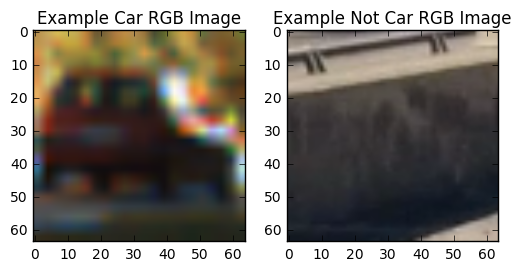

In [3]:
print('Number of car images = ', len(cars))
print('Number of not car images = ', len(notcars))
rand_car = cars[random.randint(1, len(cars))]
rand_notcar = notcars[random.randint(1, len(notcars))]
print('Random car path = ', rand_car)
print('Random not car path = ', rand_notcar)

# Plot examples
img_car = mpimg.imread(rand_car)
img_notcar = mpimg.imread(rand_notcar)
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_car)
plt.title('Example Car RGB Image')
plt.subplot(122)
plt.imshow(img_notcar)
plt.title('Example Not Car RGB Image')

## Explore histogram of gradients (HOG) features

### Define HOG function

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=False, feature_vec=True):  
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Define HOG parameters

In [5]:
# Define HOG parameters
#cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations. 6 to 12.
pix_per_cell = 8  #HOG pixels per cell
cell_per_block = 2 # HOG cells per block. Normalization happens over block.

### Test HOG with random image

HOG features native <class 'numpy.ndarray'> (7, 7, 2, 2, 9)
HOG features flattened [ 0.03259867  0.          0.05126428 ...,  0.00171201  0.00131577
  0.00322035]
HOG features stats 0.428498770083 0.0 1764 0.00777671789553


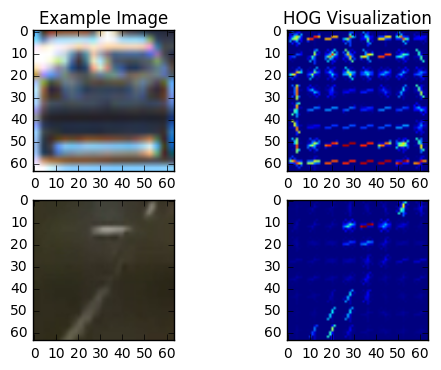

In [6]:
# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
ind_notcar = np.random.randint(0, len(cars))
rand_car = cars[random.randint(1, len(cars))]
rand_notcar = notcars[random.randint(1, len(notcars))]

# Read in the image
img_car = mpimg.imread(rand_car)
img_notcar = mpimg.imread(rand_notcar)

img_car_gray = cv2.cvtColor(img_car, cv2.COLOR_RGB2GRAY) # convert to grayscale 2D array
img_notcar_gray = cv2.cvtColor(img_notcar, cv2.COLOR_RGB2GRAY) # convert to grayscale 2D array


# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(img_car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features_notcar, hog_image_notcar = get_hog_features(img_notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(221)
plt.imshow(img_car)
plt.title('Example Image')
plt.subplot(222)
plt.imshow(hog_image_car)
plt.title('HOG Visualization')
plt.subplot(223)
plt.imshow(img_notcar)
plt.subplot(224)
plt.imshow(hog_image_notcar)

print('HOG features native', type(features_car), np.shape(features_car))
HOG_features_flattened = features_car.flatten()
print('HOG features flattened', HOG_features_flattened)
print('HOG features stats', max(HOG_features_flattened), min(HOG_features_flattened), len(HOG_features_flattened), np.median(HOG_features_flattened))


## Explore color histogram features

### Define color histogram functions

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), channel='ALL'):
    # Compute the histogram of the color channels separately
    if channel == 'ALL':
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else:
        hist_features = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        #hist_features = np.concatenate(channel_hist[0])
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), channel='ALL'):
    ## Create a list to append feature vectors to
    #features = []
    ## Iterate through the list of images
    #for file in imgs:
    # Read in each one by one
    #image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)
    
    #if channel != 'ALL':
    #    tmp_img = feature_image[:,:,channel]
    #    feature_image = tmp_img
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range, channel=channel)
    # Append the new feature vector to the features list
    #features.append(np.concatenate((spatial_features, hist_features)))
    feature_vector = np.concatenate((spatial_features, hist_features))
    ## Return list of feature vectors
    return feature_vector

### Define color histogram parameters

In [9]:
cspace_v='RGB'
spatial_size_v=(32, 32)
hist_bins_v=32
hist_range_v=(0, 256)
channel = 'ALL'

### Test new features with same images as above

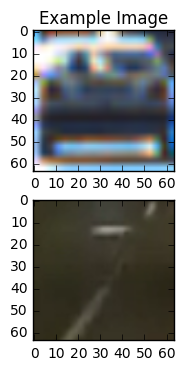

In [10]:
car_features = extract_features(img_car, cspace=cspace_v, spatial_size=spatial_size_v,
                        hist_bins=hist_bins_v, hist_range=hist_range_v, channel=channel)
notcar_features = extract_features(img_notcar, cspace=cspace_v, spatial_size=spatial_size_v,
                        hist_bins=hist_bins_v, hist_range=hist_range_v, channel=channel)
# Plot the examples
fig = plt.figure()
plt.subplot(211)
plt.imshow(img_car)
plt.title('Example Image')
plt.subplot(212)
plt.imshow(img_notcar)

In [11]:
# Examine feature vectors before scaling
print('Car', type(car_features), np.shape(car_features), min(car_features), max(car_features), np.median(car_features))
print('Not Car', type(notcar_features), np.shape(notcar_features), min(notcar_features), max(notcar_features), np.median(notcar_features))

Car <class 'numpy.ndarray'> (3168,) 0.0 4096.0 0.378921568394
Not Car <class 'numpy.ndarray'> (3168,) 0.0 4096.0 0.191176474094


## Scale feature vectors. Use color histogram as example(scale from -1 to +1, ndarray, float64)

Examining both feature vectors
X <class 'numpy.ndarray'> (2, 3168)
X_scaler <class 'sklearn.preprocessing.data.StandardScaler'> ()
scaled_X <class 'numpy.ndarray'> (2, 3168)
Car before scaling <class 'numpy.ndarray'> (3168,) 0.0 4096.0 0.378921568394
Car after scaling <class 'numpy.ndarray'> (3168,) -1.0 1.0 1.0


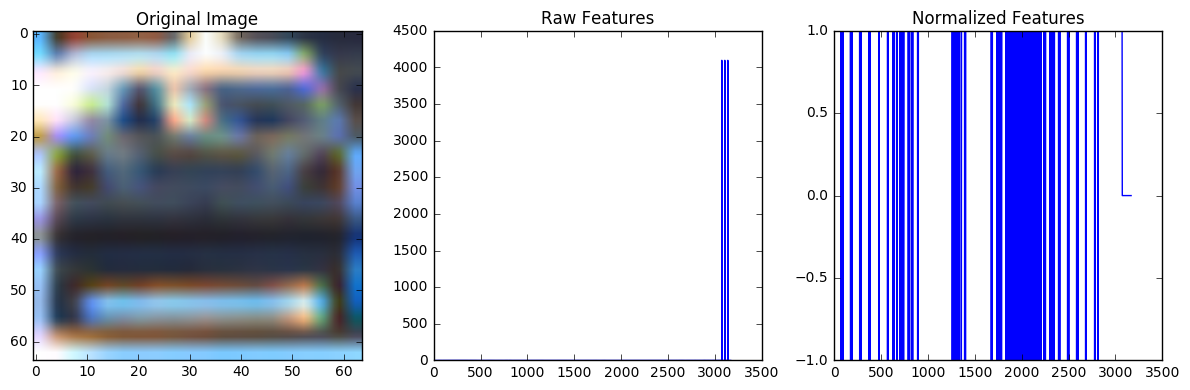

In [12]:
# Scale both feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                   
X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

# Examine feature vectors after scaling
print('Examining both feature vectors')
print('X', type(X), np.shape(X))
print('X_scaler', type(X_scaler), np.shape(X_scaler))
print('scaled_X', type(scaled_X), np.shape(scaled_X))
print('Car before scaling', type(X[0]), np.shape(X[0]), min(X[0]), max(X[0]), np.median(X[0]))
print('Car after scaling', type(scaled_X[0]), np.shape(scaled_X[0]), min(scaled_X[0]), max(scaled_X[0]), np.median(scaled_X[0]))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img_car)
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[0])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[0])
plt.title('Normalized Features')
fig.tight_layout()

X <class 'numpy.ndarray'> (3168,)
scaled_X <class 'numpy.ndarray'> (1, 3168)
Car before scaling <class 'numpy.ndarray'> (3168,) 0.0 4096.0 0.378921568394
Car after scaling <class 'numpy.ndarray'> (1, 3168) [ 0.  0.  0. ...,  0.  0.  0.] [ 0.  0.  0. ...,  0.  0.  0.] 0.0


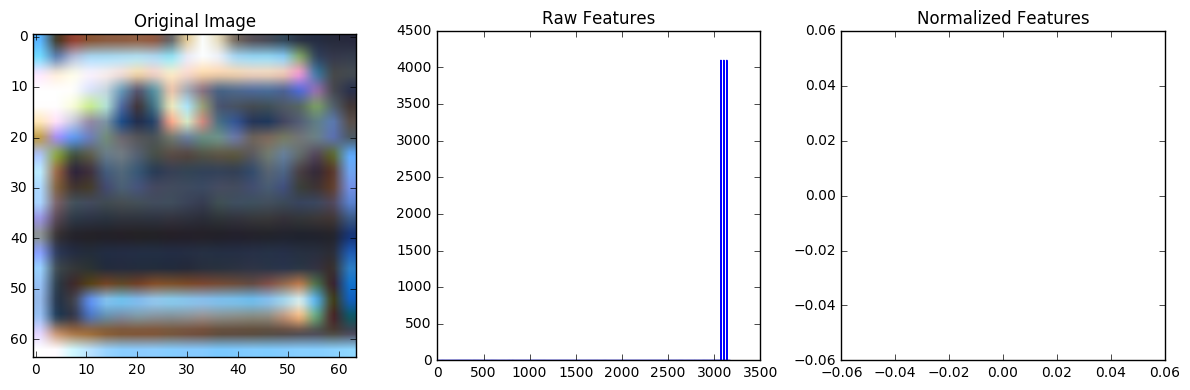

In [13]:
# Playground: How to use a single feature vector

# Scale single feature vector
#X = np.vstack((car_features, car_features)).astype(np.float64)                   
#(car_features, notcar_features)
#car_features.reshape(1,-1)
X = car_features.astype(np.float64)
scaler = StandardScaler()
#X.reshape(-1, 1)
#X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = scaler.fit_transform(X.reshape(1, -1)) # Apply the scaler to X


#X = np.array([1, -4, 5, 6, -8, 5]) # here should be your X in np.array format
#X_transformed = scaler.fit_transform(X[:, np.newaxis])

print('X', type(X), np.shape(X))
#print('X_scaler', type(X_scaler), np.shape(X_scaler))
print('scaled_X', type(scaled_X), np.shape(scaled_X))
print('Car before scaling', type(X), np.shape(X), min(X), max(X), np.median(X))
print('Car after scaling', type(scaled_X), np.shape(scaled_X), min(scaled_X), max(scaled_X), np.median(scaled_X))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img_car)
plt.title('Original Image')
plt.subplot(132)
plt.plot(X)
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X)
plt.title('Normalized Features')
fig.tight_layout()



## Define Function to Combine Features

In [14]:
def get_all_feature(img, verbose = False):
    # HOG parameters
    orient = 9 # HOG orientations. 6 to 12.
    pix_per_cell = 8  #HOG pixels per cell
    cell_per_block = 2 # HOG cells per block. Normalization happens over block.

    # Color histogram parameters
    cspace_v='HSV'
    spatial_size_v=(32, 32)
    hist_bins_v=32
    hist_range_v=(0, 256)
    channel = 'ALL'

    # Transform for HOG
    img_hog = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to grayscale 2D array
    
    # Get HOG features
    hog_features = get_hog_features(img_hog, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=False)
    hog_features_flattened = hog_features.flatten()
    #hog_scaled = hog_features_flattened - np.min(hog_features_flattened)
    #hog_scaled = hog_scaled / (2*np.max(hog_scaled))
    #hog_scaled = hog_scaled - 1
    #hog_scaled = hog_features_flattened - (np.max(hog_features_flattened) + np.min(hog_features_flattened) ) / 2
    #hog_scaled = hog_scaled / np.max(hog_features_flattened)
    #hog_scaled = hog_scaled / np.mean(hog_scaled)

    # Get color histogram features
    hist_features = extract_features(img, cspace=cspace_v, spatial_size=spatial_size_v,
                            hist_bins=hist_bins_v, hist_range=hist_range_v, channel=channel)
    hist_scaled = hist_features - np.mean(hist_features)
    
    ## Scale HOG feature vector
    #X_HOG = np.vstack(hog_features_flattened).astype(np.float64)                   
    ##X1 = hog_features_flattened.astype(np.float64)                   
    #X_HOG_scaler = StandardScaler().fit(X_HOG) # Fit a per-column scaler
    #scaled_X_HOG = X_HOG_scaler.transform(X_HOG) # Apply the scaler to X

    ## Scale histogram feature vector
    #X_hist = np.vstack(hist_features).astype(np.float64)                   
    #X_hist_scaler = StandardScaler().fit(X_hist) # Fit a per-column scaler
    #scaled_X_hist = X_hist_scaler.transform(X_hist) # Apply the scaler to X
    
    # Contatenate feature vector
    #feature_vector = np.concatenate((scaled_X_HOG, scaled_X_hist))
    feature_vector = np.concatenate((hog_features_flattened, hist_features))

    
    ## Scale concatenated feature vector
    #X_all_scalar = StandardScaler().fit(feature_vector)
    #scaled_feature_vector = X_all_scalar.transform(feature_vector)
    
    if verbose == True:
        print('HOG feature characteristics')
        print('Shape of native HOG features', np.shape(hog_features))
        print('Shape of HOG features after flattening', np.shape(hog_features_flattened))
        print('Shape, min, max, median, mean, var', np.shape(hog_features_flattened), np.min(hog_features_flattened), np.max(hog_features_flattened), np.median(hog_features_flattened), np.mean(hog_features_flattened), np.var(hog_features_flattened))
        #print('HOG scaled: Shape, min, max, median, mean, var', np.shape(hog_scaled), np.min(hog_scaled), np.max(hog_scaled), np.median(hog_scaled), np.mean(hog_scaled), np.var(hog_scaled))
        print(' ')
        print('Histogram feature characteristics')
        print('Shape of histogram features', np.shape(hist_features))
        print('Shape, min, max, median, mean, var', np.shape(hist_features), np.min(hist_features), np.max(hist_features), np.median(hist_features), np.mean(hist_features), np.var(hist_features))
        print('Hist scaled: Shape, min, max, median, mean, var', np.shape(hist_features), np.min(hist_scaled), np.max(hist_scaled), np.median(hist_scaled), np.mean(hist_scaled), np.var(hist_scaled))
        print(' ')
        #print('*******************')
        #print('Characteristics of scaled HOG features')
        #print('Shape, min, max, median, mean, var', np.shape(scaled_X_HOG), np.min(scaled_X_HOG), np.max(scaled_X_HOG), np.median(scaled_X_HOG), np.mean(scaled_X_HOG), np.var(scaled_X_HOG))
        #print(' ')
        #print('Characteristics color histogram features')
        #print('Shape, min, max, median, mean, var', np.shape(scaled_X_hist), np.min(scaled_X_hist), np.max(scaled_X_hist), np.median(scaled_X_hist), np.mean(scaled_X_hist), np.var(scaled_X_hist))
        #print(' ')
        #print('*******************')
        print('Characteristics of entire feature vector')
        #print('Shape, min, max, median, mean, var', np.shape(scaled_feature_vector), np.min(scaled_feature_vector), np.max(scaled_feature_vector), np.median(scaled_feature_vector), np.mean(scaled_feature_vector), np.var(scaled_feature_vector))
        print('Shape, min, max, median, mean, var', np.shape(feature_vector), np.min(feature_vector), np.max(feature_vector), np.median(feature_vector), np.mean(feature_vector), np.var(feature_vector))
        print(' ')
        #fig = plt.figure(figsize=(12,4))
        #plt.subplot(121)
        #plt.plot(X_HOG)
        #plt.title('HOG raw')
        #plt.subplot(122)
        #plt.plot(scaled_X_HOG)
        #plt.title('HOG normalized')
        #fig.tight_layout()  
        #print(' ')
        #fig = plt.figure(figsize=(12,4))
        #plt.subplot(121)
        #plt.plot(X_hist)
        #plt.title('Hist raw')
        #plt.subplot(122)
        #plt.plot(scaled_X_hist)
        #plt.title('Hist normalized')
        #fig.tight_layout()  
        #print(' ')
        #fig = plt.figure(figsize=(12,4))
        #plt.subplot(121)
        #plt.plot(feature_vector)
        #plt.title('All raw')
        #plt.subplot(122)
        #plt.plot(scaled_feature_vector)
        #plt.title('All normalized')
        #fig.tight_layout()  
        #print(' ')
        
    return feature_vector

### Test function in verbose form on single image

In [15]:
feature_vector = get_all_feature(img_car, verbose = True)

HOG feature characteristics
Shape of native HOG features (7, 7, 2, 2, 9)
Shape of HOG features after flattening (1764,)
Shape, min, max, median, mean, var (1764,) 0.0 0.428498770083 0.00777671789553 0.0277758202223 0.0027018103361
 
Histogram feature characteristics
Shape of histogram features (3168,)
Shape, min, max, median, mean, var (3168,) 0.0 4096.0 0.518627464771 61.221972672 19146.7361867
Hist scaled: Shape, min, max, median, mean, var (3168,) -61.221972672 4034.77802733 -60.7033452072 3.15796771449e-15 19146.7361867
 
Characteristics of entire feature vector
Shape, min, max, median, mean, var (4932,) 0.0 4096.0 0.259653672576 39.3349971557 13158.9506203
 


In [16]:
print('Feature vector', type(feature_vector), np.shape(feature_vector), min(feature_vector), max(feature_vector), np.median(feature_vector))

Feature vector <class 'numpy.ndarray'> (4932,) 0.0 4096.0 0.259653672576


## Define and use SVM classifier

In [17]:
# Review list of files
print('Number of car images = ', len(cars))
print('Number of not car images = ', len(notcars))
rand_car = cars[random.randint(1, len(cars))]
rand_notcar = notcars[random.randint(1, len(notcars))]
print('Random car path = ', rand_car)
print('Random not car path = ', rand_notcar)

Number of car images =  8792
Number of not car images =  8968
Random car path =  /Users/blakejacquot/Desktop/temp/training_images/vehicles/KITTI_extracted/5343.png
Random not car path =  /Users/blakejacquot/Desktop/temp/training_images/non-vehicles/Extras/extra2470.png


In [18]:
# Get car features
car_features = []
for file in cars:
    img = mpimg.imread(file)
    feature_vector = get_all_feature(img)
    car_features.append(feature_vector)
print(len(car_features), np.shape(car_features))

8792 (8792, 4932)


In [19]:
# Get not car features
notcar_features = []
for file in notcars:
    img = mpimg.imread(file)
    feature_vector = get_all_feature(img)
    notcar_features.append(feature_vector)
print(len(notcar_features), np.shape(notcar_features))

8968 (8968, 4932)


In [20]:
print('Shape of car and notcar features', np.shape(car_features), np.shape(notcar_features))
#car_features = np.squeeze(car_features)
#notcar_features = np.squeeze(notcar_features)
#
#print(np.shape(car_features), np.shape(notcar_features))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
print('Shape of stack of feature vectors', np.shape(X))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print('Stats of scaled X shape, min, max, mean, var', np.shape(scaled_X), np.min(scaled_X), np.max(scaled_X), np.mean(scaled_X), np.var(scaled_X))

Shape of car and notcar features (8792, 4932) (8968, 4932)
Shape of stack of feature vectors (17760, 4932)
Stats of scaled X shape, min, max, mean, var (17760, 4932) -1.97408450901 43.628026962 4.79187906963e-18 0.98702351987


In [21]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [22]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


In [23]:
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 4932
26.2 Seconds to train SVC...
Test Accuracy of SVC =  0.978
My SVC predicts:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  1.  1.  1.  0.  1.]
0.00231 Seconds to predict 10 labels with SVC


In [24]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [25]:
car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

NameError: name 'spatial' is not defined

In [ ]:
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)
